In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import pandas as pd

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)

Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=False, num_workers=2)

In [5]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionSmall(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [6]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cuda')

In [27]:
def fit(epoch, model, trainloader, testloader, optimizer,scheduler):
  history_t = {}
  history_v = {}
  criterion = nn.CrossEntropyLoss()
  for epoch in range(epoch):  
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()  
    acc_t = (correct / total)
    history_t[epoch+1] = acc_t
    scheduler.step()

    correct = 0
    total = 0
    for data in testloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()
    acc_v = (correct / total)
    history_v[epoch+1] = acc_v
    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch+1, running_loss,acc_t, acc_v))
    log_ = str(epoch+1)+","+str(acc_t)+","+str(acc_v)+"\n"
    with open("model.log", "a") as f:
      f.write(log_)
  return model,history_t,history_v

In [8]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1 = fit(100, net, trainloader, testloader, optimizer,scheduler)

Epoch 1 | loss: 2021.1163 | Train acc: 0.1245 | Val acc: 0.1539
Epoch 2 | loss: 1679.8393 | Train acc: 0.2032 | Val acc: 0.2476
Epoch 3 | loss: 1498.8844 | Train acc: 0.2799 | Val acc: 0.3188
Epoch 4 | loss: 1375.2481 | Train acc: 0.3429 | Val acc: 0.3653
Epoch 5 | loss: 1265.8656 | Train acc: 0.4003 | Val acc: 0.4315
Epoch 6 | loss: 1189.6255 | Train acc: 0.4468 | Val acc: 0.4768
Epoch 7 | loss: 1115.2057 | Train acc: 0.4851 | Val acc: 0.4779
Epoch 8 | loss: 1043.6959 | Train acc: 0.5191 | Val acc: 0.4941
Epoch 9 | loss: 980.2064 | Train acc: 0.5477 | Val acc: 0.5638
Epoch 10 | loss: 922.9494 | Train acc: 0.5789 | Val acc: 0.5785
Epoch 11 | loss: 875.3960 | Train acc: 0.6002 | Val acc: 0.6031
Epoch 12 | loss: 827.9213 | Train acc: 0.6237 | Val acc: 0.6110
Epoch 13 | loss: 786.9009 | Train acc: 0.6428 | Val acc: 0.6266
Epoch 14 | loss: 745.4008 | Train acc: 0.6638 | Val acc: 0.6429
Epoch 15 | loss: 713.9405 | Train acc: 0.6757 | Val acc: 0.6656
Epoch 16 | loss: 674.2355 | Train acc: 0.

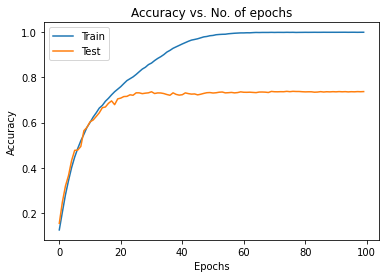

In [9]:
plt.plot(list(history_t1.values()),label='Train')
plt.plot(list(history_v1.values()),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.legend()
plt.show()

Without Batch Normalization

In [28]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionSmall2(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall2, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [30]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=False, num_workers=2)
net = InceptionSmall2().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, gamma=1.0)
trained_model2,history_t2,history_v2 = fit(100, net, trainloader, testloader, optimizer,scheduler)

Epoch 1 | loss: 1800.9625 | Train acc: 0.0975 | Val acc: 0.1000
Epoch 2 | loss: 1800.9035 | Train acc: 0.0984 | Val acc: 0.1000
Epoch 3 | loss: 1800.9329 | Train acc: 0.0972 | Val acc: 0.1000
Epoch 4 | loss: 1800.8438 | Train acc: 0.1012 | Val acc: 0.1000
Epoch 5 | loss: 1800.8454 | Train acc: 0.0980 | Val acc: 0.1000
Epoch 6 | loss: 1800.8500 | Train acc: 0.0991 | Val acc: 0.1000
Epoch 7 | loss: 1800.8179 | Train acc: 0.0998 | Val acc: 0.1000
Epoch 8 | loss: 1800.8138 | Train acc: 0.0979 | Val acc: 0.1000
Epoch 9 | loss: 1800.8045 | Train acc: 0.0987 | Val acc: 0.1000
Epoch 10 | loss: 1800.7865 | Train acc: 0.0982 | Val acc: 0.1000
Epoch 11 | loss: 1800.7538 | Train acc: 0.0997 | Val acc: 0.1000
Epoch 12 | loss: 1800.7223 | Train acc: 0.0997 | Val acc: 0.1000
Epoch 13 | loss: 1800.7363 | Train acc: 0.0983 | Val acc: 0.1000
Epoch 14 | loss: 1800.6854 | Train acc: 0.0996 | Val acc: 0.1000
Epoch 15 | loss: 1800.6919 | Train acc: 0.1006 | Val acc: 0.1000
Epoch 16 | loss: 1800.5968 | Train

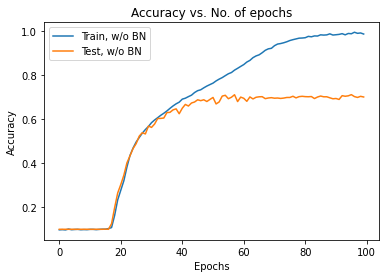

In [36]:
plt.plot(list(history_t2.values()),label='Train, w/o BN')
plt.plot(list(history_v2.values()),label='Test, w/o BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.legend()
plt.show()

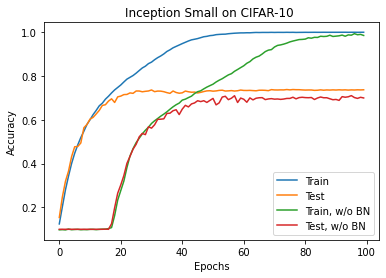

In [35]:
plt.plot(list(history_t1.values()),label='Train')
plt.plot(list(history_v1.values()),label='Test')
plt.plot(list(history_t2.values()),label='Train, w/o BN')
plt.plot(list(history_v2.values()),label='Test, w/o BN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Inception Small on CIFAR-10 ')
plt.legend()
plt.show()